# Something is growing, and it's growing very fast, but *how* fast?

Last week, I talked about engineering new features from columns you already have (I used Haversine's Formula as an example). This week, I'd like to discuss using log-transformations to test whether the underlying patterns in the data is caused by exponential behavior: `y=A*B^x` or perhaps a power model: `y=A*x^n`. NOTE: This is *not* about using log-transformations to assist with normalizing the data, for that, you'll need to look [elsewhere](http://www.blogofsomeoneinclass.com). This topic is near and dear to my heart, because it was how I met my very first tutoring client, which built into my own business over ten years. I was working at a school, and one of my fellow teachers (she specialized in Chemistry & Bio, but often helped with math at the high school level) was doing some tutoring on the side, and she ran into a group project that was focusing on exactly this topic. She wasn't feeling very confident, and knew I wasn't doing anything that night, because we had just talked about it earlier that day. So she called me, asking for help, and she paid me 100% of what she made from the family that hour. Later on, she moved away, and "gifted" me with a referral to work with that same family.  
  
Fast-forward 10 years, I'm no longer a tutor, but I have decided to take my mathematical expertise and pivot into computers, specifically, data science. Let's tie it all together. Imagine we've done some basic analysis on a few columns in pandas, and we're trying to decide on a column-by-column basis, which growth pattern is in play. Let's start with the necessary imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns    # Sidenote: if you haven't tried using the Seaborn library, it's wonderful! I highly recommend that you give it a try.
from scipy import stats
from exp_or_poly import mystery_scatter  # Secret function I wrote, don't cheat and look!
%matplotlib inline

Here is some imaginary data. This function returns a pandas dataframe which we will save as `df`

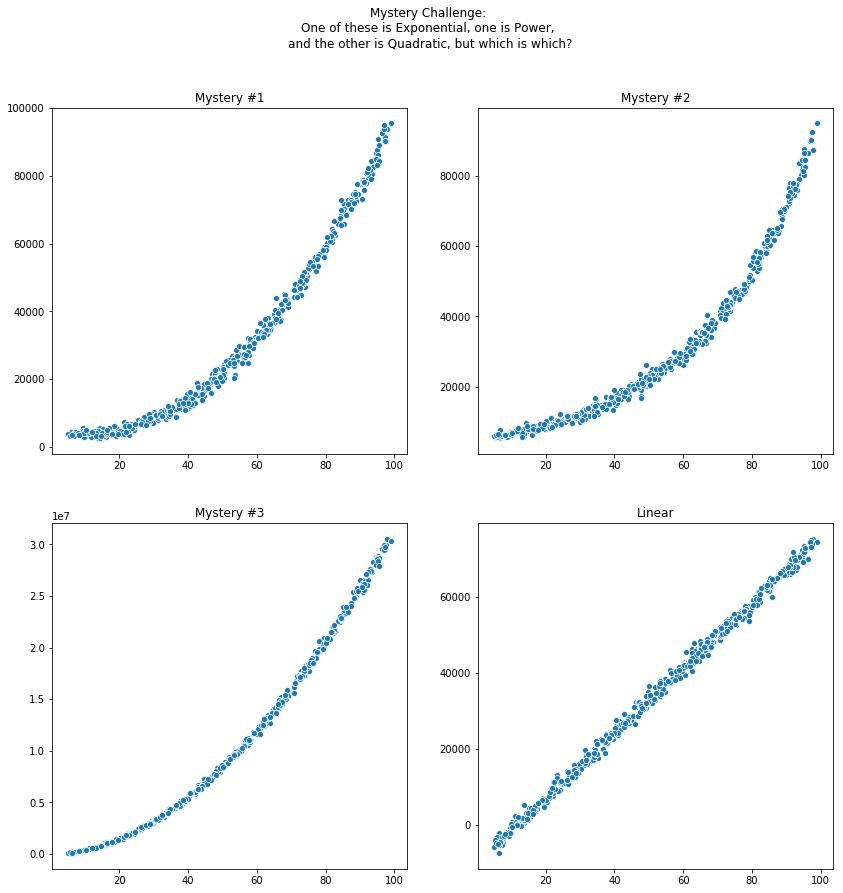

,x,mystery_1,mystery_2,mystery_3,linear
count,500.000000,500.000000,500.000000,5.000000e+02,500.000000
mean,51.595384,31372.948633,30654.424502,1.098368e+07,34111.441777
std,26.416814,25954.487664,22727.902144,8.786530e+06,22607.290150
min,5.019101,2622.068494,5451.400236,9.498159e+04,-7483.112617
25%,29.494955,8308.838700,11995.912686,3.070432e+06,14698.430889
50%,51.622231,24277.069057,23841.307039,9.079029e+06,34205.683607
75%,73.700855,49624.805802,43976.822005,1.776408e+07,52997.927645
max,98.925990,95455.331996,94890.894987,3.056593e+07,75247.568169


In [2]:
df = mystery_scatter(n=500, random=False)
df.describe()

Mysteries #1, #2, and #3 all appear quite similar, and of course #4 certainly appears linear. We could just run a bunch of different regression models on columns 1, 2, and 3, and keep track of the R^2 values, then just pick the best. In theory, this should work (and with computing power being so cheap, it's certainly not a bad idea), but I'd like to give us a more precise way to decide, instead of the "shotgun" approach where you just try all possible models. The mathematics for why the following strategy works is rather elegant, as it involves taking complicated equations and turning them into the simple linear form: `y=m*x+b`. We won't be delving into the algebra here, [but you can go here instead](https://mathbench.umd.edu/modules/misc_scaling/page11.htm). For now, we'll just practice how to make it all happen in Python.   
  
The basic idea is as follows: when looking at data that curves upward as the x variable increases, we can plot two different scatter plots, and test each of them for linearity. Whichever scatterplot is closest to a straight line will tell us which underlying growth pattern is on display. If `log(x) vs log(y)` becomes linear, then the underlying pattern came from power model growth, but if `x vs log(y)` gives the more linear scatterplot, then the original data was probably from an exponential model. 

First, let's restrict our dataframe to only the curved lines:

In [3]:
curved_data = df.drop('linear', axis=1)

Now, we'll build a function that can display the graphs side-by-side, for comparison.

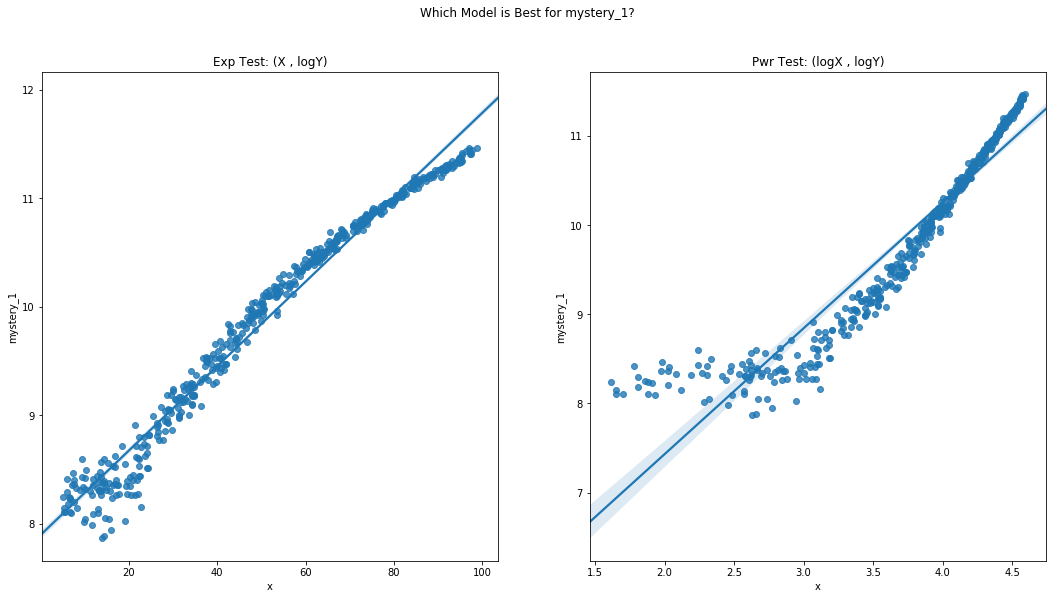

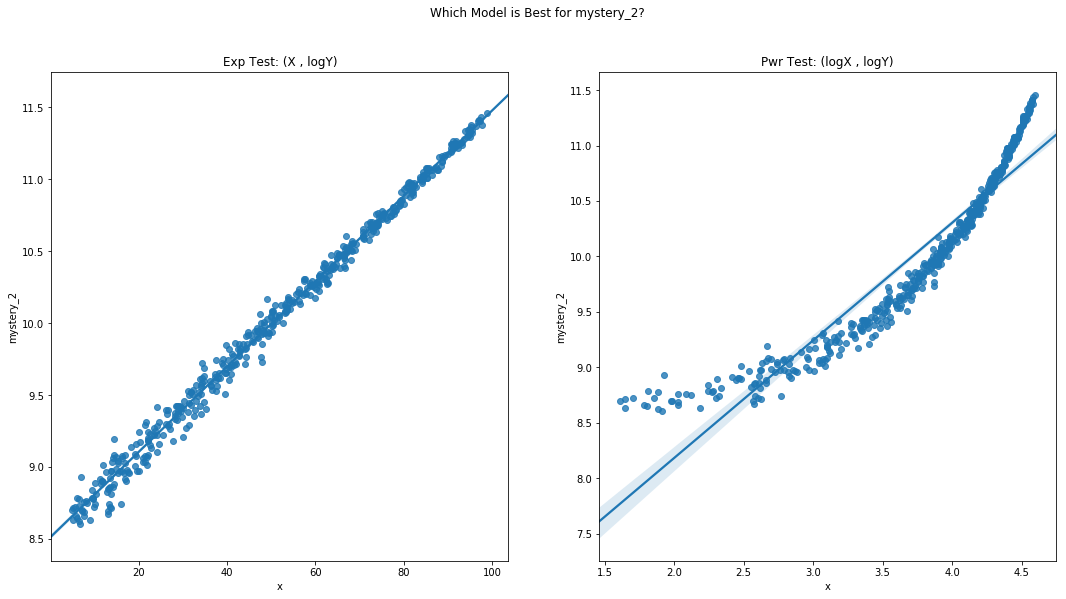

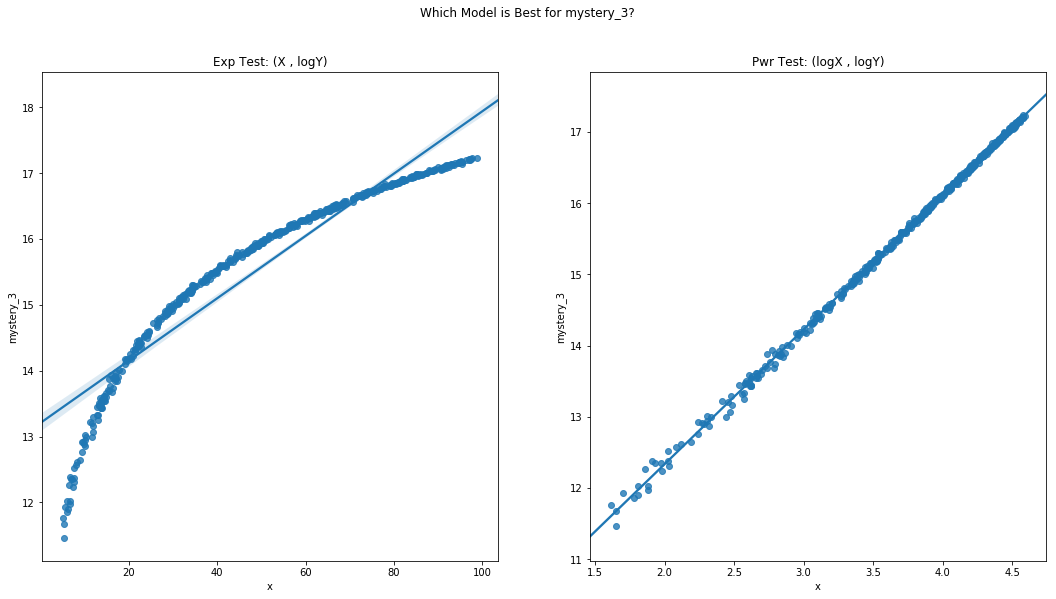

In [4]:
def linearity_test(df, x=0):
    '''Take in a dataframe, and the index for data along the x-axis. Then, for each column, 
       display a scatterplot of the (x, log(y)) and also (log(x), log(y))'''
    df_x = df.iloc[:, x].copy()
    df_y = df.drop(df.columns[x], axis=1)
    
    for col in df_y.columns:
        plt.figure(figsize=(18, 9), )
        # Is it exponential?
        
        plt.subplot(1,2,1)
        plt.title('Exp Test: (X , logY)')
        sns.regplot(df_x, np.log(df[col]))
        # Is it power?
        plt.subplot(1,2,2)
        plt.title('Pwr Test: (logX , logY)')
        sns.regplot(np.log(df_x), np.log(df[col]))
        
        plt.suptitle(f'Which Model is Best for {col}?')
        plt.show()
        plt.savefig(col+'.png')
        plt.close()
        print('')

linearity_test(curved_data)

Well, `mystery_1` seems a bit inconclusive, we'll come back to that later. `mystery_2` certainly seems to have a linear relationship on the Exp Test, but NOT for the Power Test, which means the growth pattern for that column was caused by exponential growth, and `mystery_3` is the opposite, it is very obviously linear for the Pwr Test, but not for Exp Test. Let's peek under the hood and take a look at the function I used to build this data:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def mystery_scatter(n=100, var=200, random=False):
    
    '''Randomly generate data, one of which is quadratic, another is exponential,
       and a third is linear.
       Plot all sets of data side-by-side, then return a pandas dataframe'''
    
    if random == False:
        np.random.seed(7182818)
    
    '''Generate some data, not much rhyme or reason to these numbers, just wanted everything 
       to be on the same scale and the two curved datasets should be hard to tell apart'''
    
    x = np.random.uniform(5, 100, n)
    y1 = 11.45 * x ** 2 - 234.15 * x + 5000 + np.random.normal(0, var, n) * np.sqrt(x)
    y2 = 5000 * 1.03 ** x + np.random.normal(0, var, n) * np.sqrt(x)
    y3 = 5000 * x ** 1.9 + np.random.normal(0, 20 * var, n) * x
    y4 = 856.16 * x - 10107.3 + np.random.normal(0, 6 * var, n)
    
    
    '''Graph the plots'''
    
    plt.figure(figsize=(14, 14), )
    
    plt.subplot(2,2,1)
    sns.scatterplot(x, y1)
    plt.title('Mystery #1')
    
    plt.subplot(2,2,2)
    sns.scatterplot(x, y2)
    plt.title('Mystery #2')
    
    plt.subplot(2,2,3)
    sns.scatterplot(x, y3)
    plt.title('Mystery #3')
    
    plt.subplot(2,2,4)
    sns.scatterplot(x, y4)
    plt.title('Linear')
    
    plt.suptitle('Mystery Challenge: \nOne of these is Exponential, one is Power, \nand the other is Quadratic, but which is which?')
    plt.show()
    plt.close()
    
    df = pd.DataFrame([x, y1, y2, y3, y4]).T
    df.columns = ['x', 'mystery_1', 'mystery_2', 'mystery_3', 'linear']
    df.sort_values('x', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

in particular, look at how the data was generated: 

```
x = np.random.uniform(5, 100, n)
y1 = 11.45 * x ** 2 - 234.15 * x + 5000 + np.random.normal(0, var, n) * np.sqrt(x)
y2 = 5000 * 1.03 ** x + np.random.normal(0, var, n) * np.sqrt(x)
y3 = 5000 * x ** 1.9 + np.random.normal(0, 20 * var, n) * x
y4 = 856.16 * x - 10107.3 + np.random.normal(0, 6 * var, n)
```

So we were right about `mystery_2` (which was the same as y2) being caused by exponential growth, it was `y2 = 5000*1.03^x`.  
  
Meanwhile, `mystery_1` was `y1 = 11.45*x^2 - 234.15*x + 5000`, definitely built from a quadratic equation, which is somewhat related to the Power Model, but not exactly the same. Technically, the `log(x) vs log(y)` test only forces linearity for Power Models. In order to find the exact solution for this one, we would rule out exponential growth and power growth first, then start applying the "reiterative common differences" strategy to determine the degree of the polynomial, but we won't be getting in to that here.   
  
Refocusing again on power growth: it looks like `mystery_3` was generated with `y3 = 5000*x^1.9` which definitely qualifies as a power model.
  
P.S.  If you're wondering what the extra `np.random.normal(...)` stuff at the back part of each of those lines is doing, it's just adding in some random noise so the scatter plots wouldn't be too "perfect". 